In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dmol
from dmol import color_cycle

In [3]:
# make our colors (nothing to do with the model)

vertex_colors = []
for c in color_cycle:
    hex_color = int(c[1:], 16)
    r = hex_color // 256**2
    hex_color = hex_color - r * 256**2
    g = hex_color // 256
    hex_color = hex_color - g * 256
    b = hex_color
    vertex_colors.append((r / 256, g / 256, b / 256))
vertex_colors = np.array(vertex_colors)

def z6_fxn(x):
    return vertex_colors[x]

z6_fxn(0)   

array([0.265625, 0.265625, 0.265625])

In [5]:
# make weights be 3x3 matrices at each group element
# 3x3 so that we have 3 color channels in and 3 out
weights = np.random.normal(size=(6, 3, 3))

def z6_omega(x):
    return weights[x]

z6_omega(3)

print(weights) # six 3 x 3 weight matrices

[[[-0.02818223  0.42833187  0.06651722]
  [ 0.3024719  -0.63432209 -0.36274117]
  [-0.67246045 -0.35955316 -0.81314628]]

 [[-1.7262826   0.17742614 -0.40178094]
  [-1.63019835  0.46278226 -0.90729836]
  [ 0.0519454   0.72909056  0.12898291]]

 [[ 1.13940068 -1.23482582  0.40234164]
  [-0.68481009 -0.87079715 -0.57884966]
  [-0.31155253  0.05616534 -1.16514984]]

 [[ 0.90082649  0.46566244 -1.53624369]
  [ 1.48825219  1.89588918  1.17877957]
  [-0.17992484 -1.07075262  1.05445173]]

 [[-0.40317695  1.22244507  0.20827498]
  [ 0.97663904  0.3563664   0.70657317]
  [ 0.01050002  1.78587049  0.12691209]]

 [[ 0.40198936  1.8831507  -1.34775906]
  [-1.270485    0.96939671 -1.17312341]
  [ 1.94362119 -0.41361898 -0.74745481]]]


In [6]:
# this is the inverse of the group
def z6_inv(g):
    return (6 - g) % 6

# this is the binary operation on the group
def z6_prod(g1, g2):
    return (g1 + g2) % 6

def conv(f, p):

    def out(u):
        g = np.arange(6)
        # einsum is so we can do matrix product for elements of f and g, since we have one matrix per color
        c = np.sum(np.einsum("ij,ijk->ik", f(z6_prod(u, z6_inv(g))), p(g)), axis=0)
        return c

    return out

conv(z6_fxn, z6_omega)(0)

array([ 0.17467805,  2.88853425, -3.00705901])

In [7]:
def z6_fxn_trans(g, f):
    return lambda h: f(z6_prod(z6_inv(g), h))

z6_fxn(0), z6_fxn_trans(2, z6_fxn)(0)

(array([0.265625, 0.265625, 0.265625]),
 array([0.94921875, 0.70703125, 0.3828125 ]))

In [8]:
trans_element = 2
trans_input_fxn = z6_fxn_trans(trans_element, z6_fxn)
trans_input_out = conv(trans_input_fxn, z6_omega)

In [9]:
output_fxn = conv(z6_fxn, z6_omega)
trans_output_out = z6_fxn_trans(trans_element, output_fxn)

print("g -> psi[f(g)], g -> psi[Tgf(g)], g-> Tg psi[f(g)]")
for i in range(6):
    print(
        i,
        np.round(conv(z6_fxn, z6_omega)(i), 2),
        np.round(trans_input_out(i), 2),
        np.round(trans_output_out(i), 2),
    )

g -> psi[f(g)], g -> psi[Tgf(g)], g-> Tg psi[f(g)]
0 [ 0.17  2.89 -3.01] [-0.08  2.21 -2.74] [-0.08  2.21 -2.74]
1 [ 1.46  3.28 -4.15] [-0.13  1.45 -2.01] [-0.13  1.45 -2.01]
2 [ 0.79  4.82 -1.9 ] [ 0.17  2.89 -3.01] [ 0.17  2.89 -3.01]
3 [-1.37  5.29 -3.59] [ 1.46  3.28 -4.15] [ 1.46  3.28 -4.15]
4 [-0.08  2.21 -2.74] [ 0.79  4.82 -1.9 ] [ 0.79  4.82 -1.9 ]
5 [-0.13  1.45 -2.01] [-1.37  5.29 -3.59] [-1.37  5.29 -3.59]


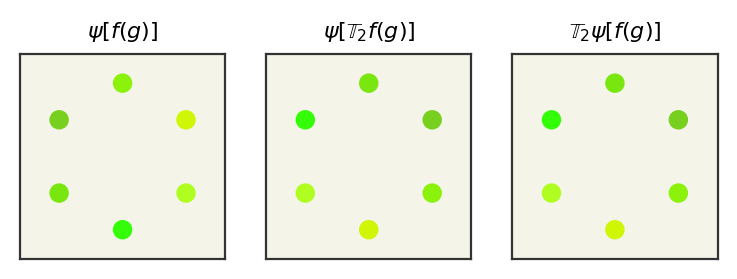

In [10]:
c1 = conv(z6_fxn, z6_omega)
c2 = trans_input_out
c3 = trans_output_out
titles = [
    r"$\psi\left[f(g)\right]$",
    r"$\psi\left[\mathbb{T}_2f(g)\right]$",
    r"$\mathbb{T}_2\psi\left[f(g)\right]$",
]


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def convert_color(r, g, b):
    h = int(sigmoid(r) * 256**3 + sigmoid(g) * 256**2 + sigmoid(b) * 256)
    return "#{:6X}".format(h)


c1 = [sigmoid(c1(i)) for i in range(6)]
c2 = [sigmoid(c2(i)) for i in range(6)]
c3 = [sigmoid(c3(i)) for i in range(6)]

fig, axs = plt.subplots(1, 3, squeeze=True)
points = np.array(
    [
        (0, 1),
        (0.5 * np.sqrt(3), 0.5),
        (0.5 * np.sqrt(3), -0.5),
        (0, -1),
        (-0.5 * np.sqrt(3), -0.5),
        (-0.5 * np.sqrt(3), 0.5),
    ]
)
for i in range(3):
    axs[i].scatter(points[:, 0], points[:, 1], color=[c1, c2, c3][i])
    # plt.plot([0, points[0,0]], [0, points[0, 1]], color='black', zorder=0)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlim(-1.4, 1.4)
    axs[i].set_ylim(-1.4, 1.4)
    axs[i].set_aspect("equal")
    axs[i].set_title(titles[i], fontsize=8)
plt.show()